In [1]:
import pandas as pd
import os
from pandas import read_csv
from pandas import read_parquet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pyarrow
import fastparquet
from datetime import datetime, timezone, timedelta
import scipy.stats as s

warnings.filterwarnings("ignore")

work_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ/data'
os.chdir(work_dir)

selected_state = 'CA'
plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font
meter_to_mile = 0.000621371

In [2]:
# load spatial labels
microtype_file = 'ccst_geoid_key_tranps_geo_with_imputation.csv'
microtype_label = read_csv(microtype_file)

microtype_label_short = microtype_label[['GEOID', 'st_code']]
microtype_label_short.head(5)

,GEOID,st_code
0,6037535001,CA
1,6037535102,CA
2,6037535101,CA
3,6037535300,CA
4,6037535200,CA


In [13]:
dist_matrix_file = 'distance_matrix_by_tracts_' + selected_state + '.csv'
cut_off = 100
dist_matrix_long = pd.read_csv('Network/combined/' + dist_matrix_file, sep = ',')
print(len(dist_matrix_long))
dist_matrix_long = dist_matrix_long.drop(columns = ['Unnamed: 0'])
dist_matrix_long = pd.merge(dist_matrix_long, microtype_label_short,
                      left_on = 'destination',
                      right_on = 'GEOID', how = 'left')

dist_matrix_long = dist_matrix_long.loc[dist_matrix_long['st_code'] == selected_state]
print(len(dist_matrix_long))
dist_matrix_long = dist_matrix_long.loc[dist_matrix_long['distance'] <= cut_off]
dist_matrix_long = dist_matrix_long.drop(columns = ['GEOID', 'st_code'])
print(len(dist_matrix_long))
dist_matrix_long.loc[:, 'origin'] = \
dist_matrix_long.loc[:, 'origin'].astype(str).str.zfill(11) 
dist_matrix_long.loc[:, 'destination'] = \
dist_matrix_long.loc[:, 'destination'].astype(str).str.zfill(11) 
dist_matrix_long.head(5)


45414791
40873038
24628276


,origin,destination,distance
1280497,06001400100,06001400100,0.000000
1280498,06001400200,06001400100,1.657105
1280499,06001400300,06001400100,2.231444
1280500,06001400400,06001400100,1.923745
1280501,06001400500,06001400100,2.218054


In [5]:
# load INRIX data
inrix_file_list = [file for file in os.listdir('INRIX/state=' + selected_state) if (file.endswith('.parquet'))]

inrix_travel_time = None
for file in inrix_file_list:
    print(file)
    data = pd.read_parquet('INRIX/state=' + selected_state + '/' + file, engine = 'auto')
#     inrix_travel_time.loc[:, 'avg_speed'] = inrix_travel_time.loc[:, 'distance_mile'] / \
#     inrix_travel_time.loc[:, 'travel_time_h']

#     data.loc[data['avg_speed'] >= 80, 'avg_speed'] = 80
    inrix_travel_time = pd.concat([inrix_travel_time, data])
    print(len(data))
#     data.head(5)
inrix_travel_time.head(5)

part-00015-8de9e788-8e39-4889-ab5e-3c9eeb9b7352.c000.snappy.parquet
28453019


,o_GEOID,d_GEOID,vehicle_weight_class,start_hour,travel_time_h,trip_distance_mile,trip_count,distance_per_trip,travel_time_per_trip
0,06037404100,06037405900,1,19,1.853611,24.752606,11,2.250237,0.168510
1,06071007800,06071002705,1,5,0.392778,14.185015,1,14.185015,0.392778
2,06001450400,06001450400,1,8,153.271667,1566.992470,805,1.946574,0.190400
3,06001451300,06001451401,1,11,39.629722,716.631893,218,3.287302,0.181788
4,06037920043,06037920043,1,12,99.127778,1554.958004,621,2.503958,0.159626


In [9]:
# post processing INRIX data
inrix_travel_time = \
inrix_travel_time.loc[inrix_travel_time['vehicle_weight_class'] == 1]
inrix_travel_time_daily = \
inrix_travel_time.groupby(['o_GEOID', 'd_GEOID'])[['travel_time_h', 'trip_distance_mile', 'trip_count']].sum()
inrix_travel_time_daily = inrix_travel_time_daily.reset_index()
print(len(inrix_travel_time_daily))
inrix_travel_time_daily.head(5)

6168007


,o_GEOID,d_GEOID,travel_time_h,trip_distance_mile,trip_count
0,06001400100,06001400100,242.157222,3295.882849,950
1,06001400100,06001400200,50.932222,548.171722,264
2,06001400100,06001400300,48.310278,625.824704,248
3,06001400100,06001400400,10.793611,135.464493,65
4,06001400100,06001400500,7.399444,91.324423,28


In [11]:
inrix_travel_time_daily.loc[:, 'avg_speed'] = \
inrix_travel_time_daily.loc[:, 'trip_distance_mile'] / \
inrix_travel_time_daily.loc[:, 'travel_time_h']

inrix_travel_time_daily.loc[:, 'distance_mile'] = \
inrix_travel_time_daily.loc[:, 'trip_distance_mile'] / \
inrix_travel_time_daily.loc[:, 'trip_count']

inrix_travel_time_daily.loc[:, 'travel_time_h'] = \
inrix_travel_time_daily.loc[:, 'travel_time_h'] / \
inrix_travel_time_daily.loc[:, 'trip_count']

inrix_travel_time_daily.loc[inrix_travel_time_daily['avg_speed'] >= 80, 'avg_speed'] = 80
print(len(inrix_travel_time_daily))
inrix_travel_time_daily.head(5)

6168007


,o_GEOID,d_GEOID,travel_time_h,trip_distance_mile,trip_count,avg_speed,distance_mile
0,06001400100,06001400100,0.254902,3295.882849,950,13.610508,3.469350
1,06001400100,06001400200,0.192925,548.171722,264,10.762769,2.076408
2,06001400100,06001400300,0.194800,625.824704,248,12.954277,2.523487
3,06001400100,06001400400,0.166056,135.464493,65,12.550433,2.084069
4,06001400100,06001400500,0.264266,91.324423,28,12.342065,3.261587


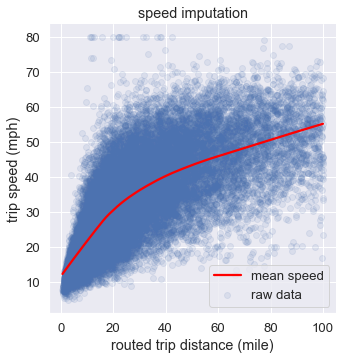

In [12]:
sample_inrix_travel_time = inrix_travel_time_daily.sample(frac = 0.005)
sample_inrix_travel_time = sample_inrix_travel_time[sample_inrix_travel_time['distance_mile'] <= 100]
sns.lmplot(x="distance_mile", y="avg_speed",  
           data=sample_inrix_travel_time, lowess=True, 
           scatter_kws={'alpha':0.1},
           line_kws={'color': 'red'})
# plt.xlim([0,100])
plt.xlabel('routed trip distance (mile)')
plt.ylabel('trip speed (mph)')
plt.legend(['mean speed', 'raw data'])
plt.title('speed imputation')

plt.show()

In [14]:
# dist_matrix_long[['origin', 'destination']] = \
# dist_matrix_long[['origin', 'destination']].astype(int)
# inrix_travel_time[['o_GEOID', 'd_GEOID']] = \
# inrix_travel_time[['o_GEOID', 'd_GEOID']].astype(int)

dist_and_time_matrix = pd.merge(dist_matrix_long, 
                                inrix_travel_time_daily, 
                                left_on = ['origin', 'destination'],
                                right_on = ['o_GEOID', 'd_GEOID'],
                                how = 'left')
dist_and_time_matrix.head(5)

,origin,destination,distance,o_GEOID,d_GEOID,travel_time_h,trip_distance_mile,trip_count,avg_speed,distance_mile
0,06001400100,06001400100,0.000000,06001400100,06001400100,0.254902,3295.882849,950.0,13.610508,3.469350
1,06001400200,06001400100,1.657105,06001400200,06001400100,0.170920,528.118910,285.0,10.841610,1.853049
2,06001400300,06001400100,2.231444,06001400300,06001400100,0.210231,720.141180,281.0,12.190287,2.562780
3,06001400400,06001400100,1.923745,06001400400,06001400100,0.193547,144.776990,69.0,10.840884,2.098217
4,06001400500,06001400100,2.218054,06001400500,06001400100,0.279722,71.896285,26.0,9.885671,2.765242


In [15]:
import statsmodels.api as sm
dist_and_time_matrix_train = dist_and_time_matrix.dropna()
X = dist_and_time_matrix_train['distance']
y = dist_and_time_matrix_train['distance_mile']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          distance_mile   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 8.005e+07
Date:                Wed, 19 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:23:54   Log-Likelihood:            -1.9522e+07
No. Observations:             5898636   AIC:                         3.904e+07
Df Residuals:                 5898634   BIC:                         3.904e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3218      0.004    552.274      0.0

In [18]:
print(est2.params)
print(est2.params['const'])
print(est2.params['distance'])

const       2.321815
distance    1.199898
dtype: float64
2.3218148153185925
1.1998979596835153


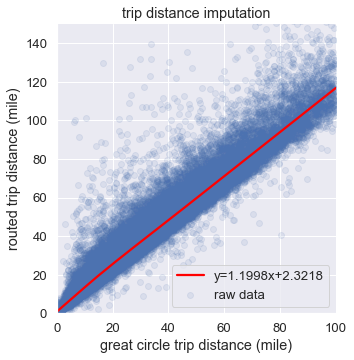

In [19]:
sample_inrix_travel_time_train = dist_and_time_matrix_train.sample(frac = 0.01)
sns.lmplot(x="distance", y="distance_mile",  
           data = sample_inrix_travel_time_train, lowess=True, 
           scatter_kws={'alpha':0.1},
           line_kws={'color': 'red'})
plt.xlim([0,100])
plt.ylim([0,150])
plt.xlabel('great circle trip distance (mile)')
plt.ylabel('routed trip distance (mile)')
plt.legend(['y=1.1998x+2.3218', 'raw data'])
plt.title('trip distance imputation')

plt.show()

In [20]:
dist_and_time_matrix_train.loc[:, 'distance_bin'] = \
dist_and_time_matrix_train.loc[:, 'distance_mile'].astype(int)
mean_speed_lookup = \
dist_and_time_matrix_train.groupby('distance_bin')[['avg_speed']].mean()
mean_speed_lookup = mean_speed_lookup.reset_index()
mean_speed_lookup.head(5)

,distance_bin,avg_speed
0,0,7.831680
1,1,10.769142
2,2,12.780306
3,3,14.333760
4,4,15.720744


In [22]:
dist_and_time_matrix_to_fill = dist_and_time_matrix[dist_and_time_matrix.isna().any(axis=1)]
dist_and_time_matrix_to_fill.head(5)
dist_and_time_matrix_to_fill.loc[:, 'distance_mile'] = \
est2.params['distance'] * dist_and_time_matrix_to_fill.loc[:, 'distance'] + est2.params['const']

dist_and_time_matrix_to_fill.loc[:, 'distance_bin'] = \
dist_and_time_matrix_to_fill.loc[:, 'distance_mile'].astype(int)

dist_and_time_matrix_to_fill = dist_and_time_matrix_to_fill.drop(columns=['avg_speed'])
dist_and_time_matrix_to_fill = pd.merge(dist_and_time_matrix_to_fill,
                                        mean_speed_lookup,
                                        on = 'distance_bin',
                                        how = 'left')

In [23]:

max_speed = mean_speed_lookup.avg_speed.max()
print(max_speed)
dist_and_time_matrix_to_fill.loc[:, 'avg_speed'] = \
dist_and_time_matrix_to_fill.loc[:, 'avg_speed'].fillna(max_speed)
dist_and_time_matrix_to_fill.loc[:, 'travel_time_h'] = \
dist_and_time_matrix_to_fill.loc[:, 'distance_mile'] / \
dist_and_time_matrix_to_fill.loc[:, 'avg_speed']
dist_and_time_matrix_to_fill.head(5)

73.7111811591902


,origin,destination,distance,o_GEOID,d_GEOID,travel_time_h,trip_distance_mile,trip_count,distance_mile,distance_bin,avg_speed
0,06001405800,06001400100,5.092027,NaN,NaN,0.399796,NaN,NaN,8.431728,8,21.090076
1,06001406500,06001400100,5.559215,NaN,NaN,0.426376,NaN,NaN,8.992306,8,21.090076
2,06001407101,06001400100,5.917569,NaN,NaN,0.421318,NaN,NaN,9.422294,9,22.363843
3,06001408400,06001400100,7.860745,NaN,NaN,0.477062,NaN,NaN,11.753907,11,24.638098
4,06001408500,06001400100,7.962388,NaN,NaN,0.482012,NaN,NaN,11.875868,11,24.638098


In [24]:
output_attr = ['origin', 'destination',	'distance',	 'distance_mile',  'travel_time_h', 'avg_speed']
dist_and_time_matrix_to_fill = dist_and_time_matrix_to_fill[output_attr]
dist_and_time_matrix_train = dist_and_time_matrix_train[output_attr]
dist_and_time_matrix_out = pd.concat([dist_and_time_matrix_to_fill, 
                                      dist_and_time_matrix_train])
print(sum(dist_and_time_matrix_out.isna().any(axis=1)))
dist_and_time_matrix_out.head(5)


0


,origin,destination,distance,distance_mile,travel_time_h,avg_speed
0,06001405800,06001400100,5.092027,8.431728,0.399796,21.090076
1,06001406500,06001400100,5.559215,8.992306,0.426376,21.090076
2,06001407101,06001400100,5.917569,9.422294,0.421318,22.363843
3,06001408400,06001400100,7.860745,11.753907,0.477062,24.638098
4,06001408500,06001400100,7.962388,11.875868,0.482012,24.638098


In [25]:
dist_and_time_matrix_out.to_csv('Network/' + selected_state + '/travel_time_skim_V2.csv')

In [26]:
dist_and_time_matrix_check = dist_and_time_matrix_out[dist_and_time_matrix_out.isna().any(axis=1)]
dist_and_time_matrix_check.head(5)
print(sum(dist_and_time_matrix_out.isna().any(axis=1)))

0
